In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

# __1. 데이터 프레임 전처리__

In [2]:
dt = pd.read_csv('./03_oil_value_ts.csv')
dt.head(10)

,Code,Statistics,Fuel Type,Sulfur Content,Viscosity,Delivery Type,Location,Country,Continent,2022-01-04,...,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22
0,PPXDK00,CLOSE,Fuel Oil,3.5%,380 CST,FOB,Singapore,Singapore,Asia,434.04,...,491.9,490.855,489.81,492.18,490.35,500.33,500.50,495.32,499.21,489.36
1,PUABC00,CLOSE,Fuel Oil,3.5%,Unknown,FOB,Rotterdam,Netherlands,Europe,430.50,...,474.0,466.750,472.50,479.00,472.00,485.00,482.75,477.00,472.75,467.50
2,PUAFT00,CLOSE,Bunker Fuel Oil,Unknown,380 CST,Delivered,Singapore,Singapore,Asia,447.00,...,507.0,506.000,505.00,507.00,505.00,507.00,512.00,509.00,513.00,507.00
3,AALMZ00,CLOSE,Marine Gasoil,0.5%,Unknown,Delivered,Singapore,Singapore,Asia,684.00,...,810.0,810.000,810.00,803.00,798.00,805.00,801.00,765.00,763.00,760.00
4,PUAFN00,CLOSE,Bunker Fuel Oil,3.5%,380 CST,Delivered,Rotterdam,Netherlands,Europe,439.00,...,475.0,468.000,472.00,496.00,474.00,486.00,483.00,477.00,476.00,469.00
5,AAYWT00,CLOSE,Gasoil,0.1%,Unknown,FOB,ARA Barge,Netherlands/Belgium,Europe,672.25,...,816.0,801.250,800.50,816.75,794.00,795.50,784.75,756.75,759.00,758.50
6,AARTG00,CLOSE,Marine Gasoil,0.1%,Unknown,Delivered,Rotterdam,Netherlands,Europe,670.00,...,805.0,797.000,800.00,805.00,790.00,790.00,780.00,760.00,750.00,750.00
7,AARKD00,CLOSE,Bunker Fuel Oil,Unknown,380 CST,Delivered,Shanghai,China,Asia,505.00,...,504.0,504.500,505.00,510.00,507.00,518.00,521.00,519.00,523.00,517.00
8,AARKE00,CLOSE,Marine Gasoil,0.5%,Unknown,Delivered,Shanghai,China,Asia,785.00,...,850.0,850.000,850.00,846.00,840.00,845.00,845.00,833.00,825.00,820.00
9,PUAFL00,CLOSE,Bunker Fuel Oil,3.5%,380 CST,Delivered,Piraeus,Greece,Europe,468.00,...,540.0,535.000,535.00,535.00,540.00,535.00,540.00,540.00,540.00,540.00


In [3]:
dt = dt[dt['Statistics'] == 'CLOSE'].drop(['Code', 'Country', 'Viscosity'], axis=1)

In [4]:
dt['Fuel Type'] = dt['Fuel Type'] + ' ' + (dt.groupby('Fuel Type').cumcount() + 1).astype(str)
dt

,Statistics,Fuel Type,Sulfur Content,Delivery Type,Location,Continent,2022-01-04,2022-01-05,2022-01-06,2022-01-07,...,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22
0,CLOSE,Fuel Oil 1,3.5%,FOB,Singapore,Asia,434.04,436.28,438.37,450.78,...,491.90,490.855,489.81,492.18,490.35,500.33,500.50,495.32,499.21,489.36
1,CLOSE,Fuel Oil 2,3.5%,FOB,Rotterdam,Europe,430.50,437.75,444.00,442.00,...,474.00,466.750,472.50,479.00,472.00,485.00,482.75,477.00,472.75,467.50
2,CLOSE,Bunker Fuel Oil 1,Unknown,Delivered,Singapore,Asia,447.00,449.00,451.00,463.00,...,507.00,506.000,505.00,507.00,505.00,507.00,512.00,509.00,513.00,507.00
3,CLOSE,Marine Gasoil 1,0.5%,Delivered,Singapore,Asia,684.00,694.00,698.00,709.00,...,810.00,810.000,810.00,803.00,798.00,805.00,801.00,765.00,763.00,760.00
4,CLOSE,Bunker Fuel Oil 2,3.5%,Delivered,Rotterdam,Europe,439.00,445.00,456.00,456.00,...,475.00,468.000,472.00,496.00,474.00,486.00,483.00,477.00,476.00,469.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,CLOSE,Fuel Oil 5,3.5%,CIF,Med Cargo,Europe,436.00,442.00,449.75,446.75,...,493.50,491.250,498.25,505.50,498.50,506.00,501.75,496.00,492.00,487.75
89,CLOSE,Gasoil 6,0.1%,CIF,Med Cargo,Europe,690.50,706.75,715.25,715.50,...,835.75,831.000,830.50,846.00,822.25,821.75,810.75,779.00,781.00,783.00
92,CLOSE,Gasoil 7,0.1%,CIF,NWE Cargo,Europe,NaN,NaN,NaN,NaN,...,821.25,813.250,813.00,829.00,806.25,808.00,797.50,770.50,773.00,772.25
94,CLOSE,Marine Fuel 3,0.5%,Delivered,Santos,South America,NaN,NaN,NaN,NaN,...,676.00,677.000,670.00,672.00,668.00,670.00,664.00,659.00,661.00,649.00


In [5]:
date_columns = dt.columns[6:]
date_columns

Index(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10',
       '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
       ...
       '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
       '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22'],
      dtype='object', length=595)

In [6]:
dt_fuel = dt.loc[:, date_columns].T
dt_fuel.columns = dt['Fuel Type']
dt_fuel.index = pd.to_datetime(dt_fuel.index)
dt_fuel

Fuel Type,Fuel Oil 1,Fuel Oil 2,Bunker Fuel Oil 1,Marine Gasoil 1,Bunker Fuel Oil 2,Gasoil 1,Marine Gasoil 2,Bunker Fuel Oil 3,Marine Gasoil 3,Bunker Fuel Oil 4,...,Marine Fuel 2,Bunker Fuel Oil 28,Marine Gasoil 36,Fuel Oil 4,Gasoil 5,Fuel Oil 5,Gasoil 6,Gasoil 7,Marine Fuel 3,Marine Gasoil 37
2022-01-04,434.04,430.50,447.0,684.0,439.0,672.25,670.0,505.0,785.0,468.0,...,569.00,493.0,715.0,427.50,673.75,436.00,690.50,NaN,NaN,NaN
2022-01-05,436.28,437.75,449.0,694.0,445.0,692.25,685.0,508.0,785.0,470.0,...,576.00,495.0,720.0,433.75,690.75,442.00,706.75,NaN,NaN,NaN
2022-01-06,438.37,444.00,451.0,698.0,456.0,701.25,703.0,510.0,785.0,473.0,...,581.50,501.0,730.0,441.50,699.25,449.75,715.25,NaN,NaN,NaN
2022-01-07,450.78,442.00,463.0,709.0,456.0,702.25,700.0,520.0,797.0,475.0,...,581.50,502.0,740.0,438.00,700.25,446.75,715.50,NaN,NaN,NaN
2022-01-10,448.57,437.25,461.0,712.0,451.0,698.75,702.0,515.0,790.0,479.0,...,582.50,505.0,740.0,433.00,698.50,441.75,713.25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,500.33,485.00,507.0,805.0,486.0,795.50,790.0,518.0,845.0,535.0,...,622.25,583.0,853.0,494.00,802.50,506.00,821.75,808.00,670.0,904.0
2024-04-17,500.50,482.75,512.0,801.0,483.0,784.75,780.0,521.0,845.0,540.0,...,614.75,577.0,850.0,489.75,789.25,501.75,810.75,797.50,664.0,900.0
2024-04-18,495.32,477.00,509.0,765.0,477.0,756.75,760.0,519.0,833.0,540.0,...,602.25,570.0,830.0,484.00,758.00,496.00,779.00,770.50,659.0,896.0
2024-04-19,499.21,472.75,513.0,763.0,476.0,759.00,750.0,523.0,825.0,540.0,...,602.00,570.0,825.0,480.00,761.00,492.00,781.00,773.00,661.0,899.0


In [7]:
# 결측치 컬럼 삭제
dt_fuel = dt_fuel.iloc[:, :-3]
dt_fuel

Fuel Type,Fuel Oil 1,Fuel Oil 2,Bunker Fuel Oil 1,Marine Gasoil 1,Bunker Fuel Oil 2,Gasoil 1,Marine Gasoil 2,Bunker Fuel Oil 3,Marine Gasoil 3,Bunker Fuel Oil 4,...,Marine Gasoil 34,Marine Gasoil 35,Marine Fuel 1,Marine Fuel 2,Bunker Fuel Oil 28,Marine Gasoil 36,Fuel Oil 4,Gasoil 5,Fuel Oil 5,Gasoil 6
2022-01-04,434.04,430.50,447.0,684.0,439.0,672.25,670.0,505.0,785.0,468.0,...,699.0,705.0,561.50,569.00,493.0,715.0,427.50,673.75,436.00,690.50
2022-01-05,436.28,437.75,449.0,694.0,445.0,692.25,685.0,508.0,785.0,470.0,...,715.0,705.0,568.50,576.00,495.0,720.0,433.75,690.75,442.00,706.75
2022-01-06,438.37,444.00,451.0,698.0,456.0,701.25,703.0,510.0,785.0,473.0,...,734.0,705.0,574.00,581.50,501.0,730.0,441.50,699.25,449.75,715.25
2022-01-07,450.78,442.00,463.0,709.0,456.0,702.25,700.0,520.0,797.0,475.0,...,725.0,705.0,573.75,581.50,502.0,740.0,438.00,700.25,446.75,715.50
2022-01-10,448.57,437.25,461.0,712.0,451.0,698.75,702.0,515.0,790.0,479.0,...,735.0,710.0,574.75,582.50,505.0,740.0,433.00,698.50,441.75,713.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,500.33,485.00,507.0,805.0,486.0,795.50,790.0,518.0,845.0,535.0,...,860.0,717.0,611.50,622.25,583.0,853.0,494.00,802.50,506.00,821.75
2024-04-17,500.50,482.75,512.0,801.0,483.0,784.75,780.0,521.0,845.0,540.0,...,850.0,717.0,604.00,614.75,577.0,850.0,489.75,789.25,501.75,810.75
2024-04-18,495.32,477.00,509.0,765.0,477.0,756.75,760.0,519.0,833.0,540.0,...,835.0,716.0,591.50,602.25,570.0,830.0,484.00,758.00,496.00,779.00
2024-04-19,499.21,472.75,513.0,763.0,476.0,759.00,750.0,523.0,825.0,540.0,...,855.0,717.0,591.25,602.00,570.0,825.0,480.00,761.00,492.00,781.00


In [8]:
dt_fuel_mg = dt_fuel.filter(regex='Marine Gasoil')
dt_fuel_mg

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 27,Marine Gasoil 28,Marine Gasoil 29,Marine Gasoil 30,Marine Gasoil 31,Marine Gasoil 32,Marine Gasoil 33,Marine Gasoil 34,Marine Gasoil 35,Marine Gasoil 36
2022-01-04,684.0,670.0,785.0,701.0,700.0,735.0,708.25,777.0,775.5,757.0,...,797.0,809.0,754.0,713.0,670.0,775.0,702.0,699.0,705.0,715.0
2022-01-05,694.0,685.0,785.0,710.0,705.0,755.0,722.25,778.0,800.5,782.0,...,822.0,834.0,762.0,727.0,685.0,770.0,715.0,715.0,705.0,720.0
2022-01-06,698.0,703.0,785.0,711.0,709.0,760.0,715.00,785.0,802.5,784.0,...,824.0,836.0,773.0,747.0,703.0,770.0,733.0,734.0,705.0,730.0
2022-01-07,709.0,700.0,797.0,720.0,715.0,770.0,733.00,786.0,806.5,788.0,...,828.0,840.0,768.0,749.0,700.0,780.0,727.0,725.0,705.0,740.0
2022-01-10,712.0,702.0,790.0,720.0,718.0,795.0,736.00,792.0,813.5,795.0,...,835.0,847.0,775.0,750.0,702.0,785.0,725.0,735.0,710.0,740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,805.0,790.0,845.0,880.0,808.0,900.0,816.50,911.0,876.5,858.0,...,869.0,881.0,900.0,865.0,790.0,890.0,870.0,860.0,717.0,853.0
2024-04-17,801.0,780.0,845.0,875.0,808.0,900.0,814.50,893.0,865.5,847.0,...,858.0,870.0,890.0,860.0,780.0,894.0,870.0,850.0,717.0,850.0
2024-04-18,765.0,760.0,833.0,865.0,782.0,890.0,799.50,883.0,859.5,841.0,...,852.0,864.0,880.0,850.0,760.0,885.0,840.0,835.0,716.0,830.0
2024-04-19,763.0,750.0,825.0,855.0,772.0,875.0,792.50,884.0,860.5,842.0,...,853.0,865.0,878.0,840.0,750.0,880.0,830.0,855.0,717.0,825.0


# __2. 시계열 데이터 전처리__

In [9]:
ts = dt_fuel_mg['Marine Gasoil 9']
ts = pd.DataFrame(ts)
ts.index.name = 'Date'
ts.rename(columns={'Marine Gasoil 9': 'Marine Gasoil 9_Price'}, inplace=True)
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


In [10]:
ts.to_csv('05_MG9_ts.csv')

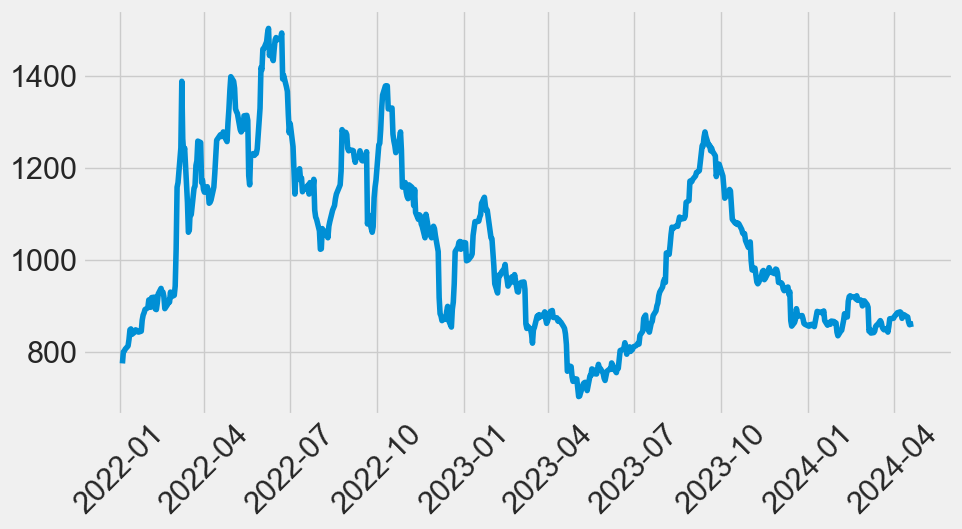

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.xticks(rotation=45)
plt.plot(ts);

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

# __3. 데이터 분리__

In [13]:
last_date = ts.index.max()
last_date

Timestamp('2024-04-22 00:00:00')

In [14]:
test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((585, 1), (10, 1))

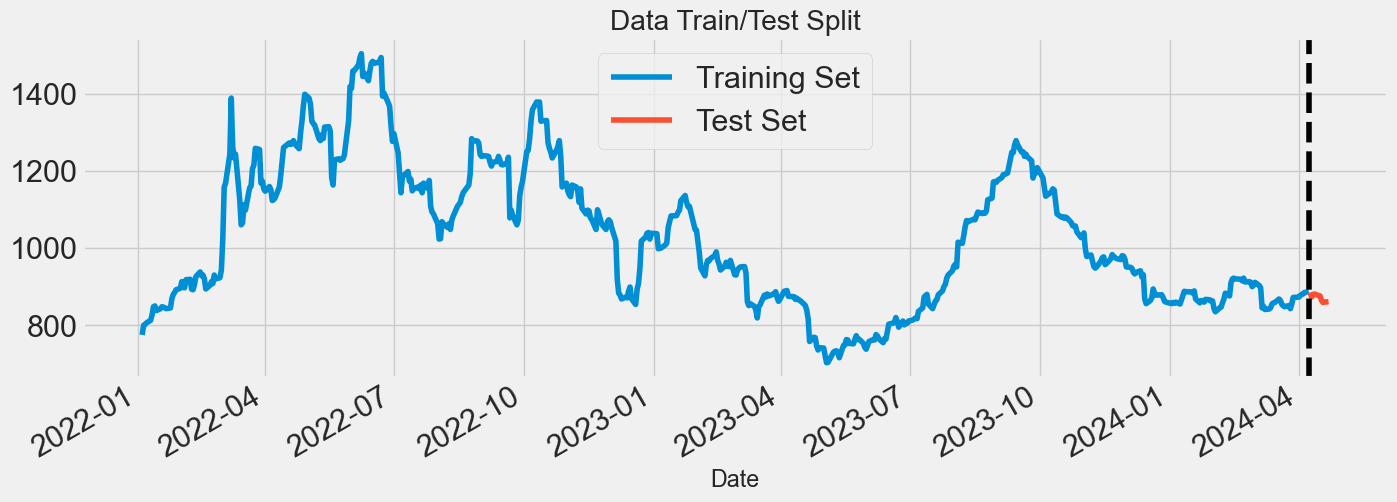

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

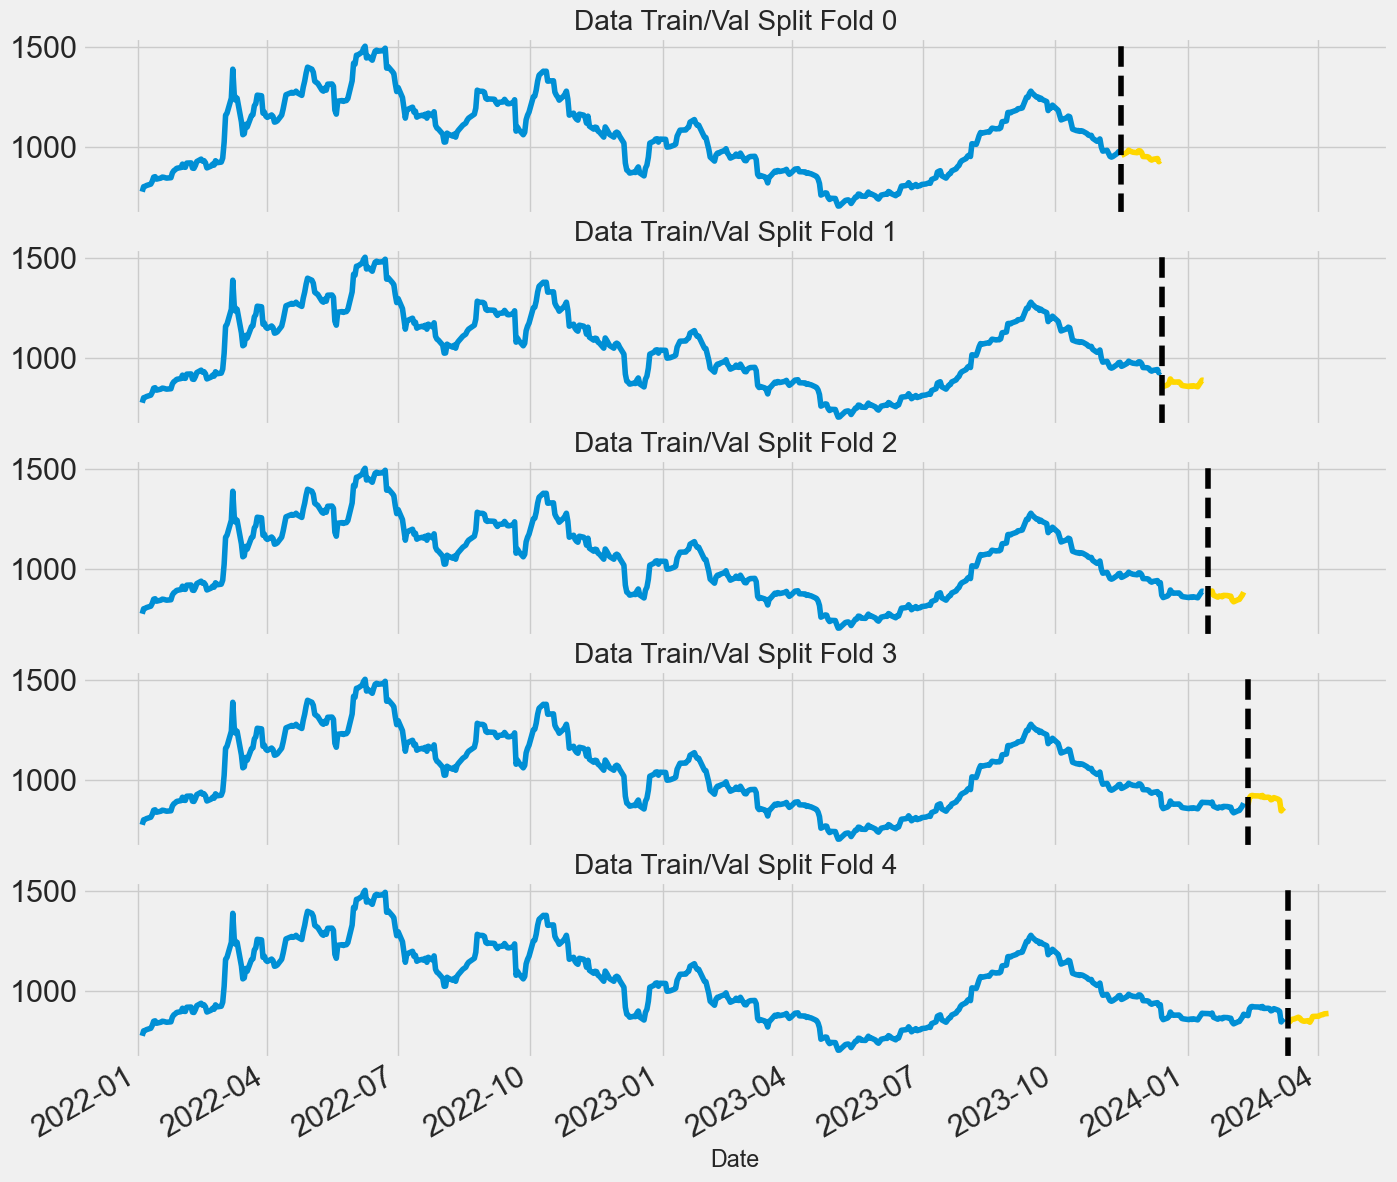

In [16]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size=20)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_val):
    train = train_val.iloc[train_idx]
    validation = train_val.iloc[val_idx]
    train['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Val Split Fold {fold}')
    validation['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Test Set', color='gold')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [17]:
train_val.shape, test.shape

((585, 1), (10, 1))

# __5. Feature Engineering__

## __5.1 Trend, Seasonal__

In [18]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal
train_val.head(20)

,Marine Gasoil 9_Price,trend,seasonal
Date,,,
2022-01-04,775.5,846.550,-1.554101
2022-01-05,800.5,846.550,-3.835135
2022-01-06,802.5,846.550,-1.155825
2022-01-07,806.5,846.550,1.645037
2022-01-10,813.5,846.550,6.737278
2022-01-11,827.5,846.550,-2.680333
2022-01-12,848.5,846.550,-2.934797
2022-01-13,850.5,846.550,-2.422594
2022-01-14,838.5,846.550,-5.157713


In [19]:
test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal
test.shape

(10, 3)

## __5.2 Moving Averages__

In [20]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

In [21]:
# 5일(1주), 10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
train_val.head(20)

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_rolling240
Date,,,,,,,,,
2022-01-04,775.5,846.550,-1.554101,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-05,800.5,846.550,-3.835135,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-06,802.5,846.550,-1.155825,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-07,806.5,846.550,1.645037,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-10,813.5,846.550,6.737278,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-11,827.5,846.550,-2.680333,810.1,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-12,848.5,846.550,-2.934797,819.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-13,850.5,846.550,-2.422594,829.3,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-14,838.5,846.550,-5.157713,835.7,820.7,843.1,975.375,1141.545833,1160.53125


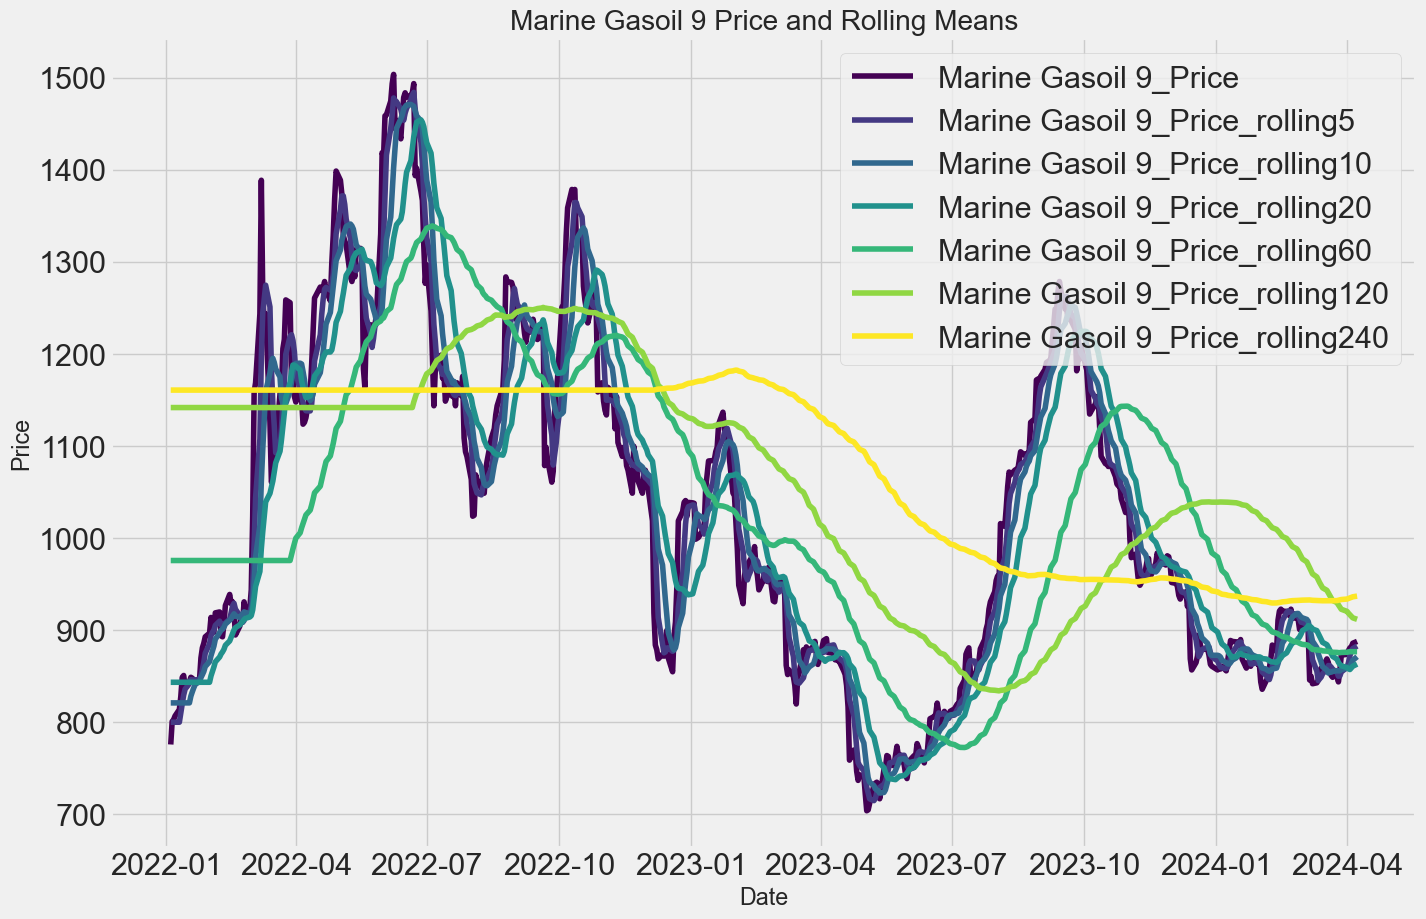

In [22]:
columns_to_plot = [
    'Marine Gasoil 9_Price',
    'Marine Gasoil 9_Price_rolling5',
    'Marine Gasoil 9_Price_rolling10',
    'Marine Gasoil 9_Price_rolling20',
    'Marine Gasoil 9_Price_rolling60',
    'Marine Gasoil 9_Price_rolling120',
    'Marine Gasoil 9_Price_rolling240'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [23]:
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test.shape

(10, 9)

## __5.3 Lag feature__

In [24]:
def add_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    target_map = df[col_name].to_dict()
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = (df.index - pd.Timedelta(days=days)).map(target_map)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

In [25]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])

In [26]:
train_val

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_rolling240,Marine Gasoil 9_Price_lag5,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,Marine Gasoil 9_Price_lag240,Marine Gasoil 9_Price_lag480
Date,,,,,,,,,,,,,,,,
2022-01-04,775.5,846.550,-1.554101,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,775.5,775.5,802.5,775.5,775.5,802.5
2022-01-05,800.5,846.550,-3.835135,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,775.5,775.5,802.5,775.5,775.5,802.5
2022-01-06,802.5,846.550,-1.155825,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,775.5,775.5,802.5,775.5,775.5,802.5
2022-01-07,806.5,846.550,1.645037,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,775.5,775.5,802.5,775.5,775.5,802.5
2022-01-10,813.5,846.550,6.737278,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,775.5,775.5,802.5,775.5,775.5,802.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,877.5,869.800,-1.554101,864.5,859.2,857.80,876.083333,918.108333,934.102083,872.5,851.5,855.5,835.5,950.5,1012.5,868.5
2024-04-03,880.5,870.025,-3.835135,871.9,860.8,856.95,876.316667,916.375000,934.677083,880.5,851.5,858.5,845.5,947.5,1012.5,873.5
2024-04-04,881.5,870.175,-1.155825,877.1,863.5,858.75,876.383333,914.716667,935.260417,880.5,851.5,859.5,845.5,937.5,1032.5,873.5


In [27]:
train_val.shape, test.shape

((585, 16), (10, 16))

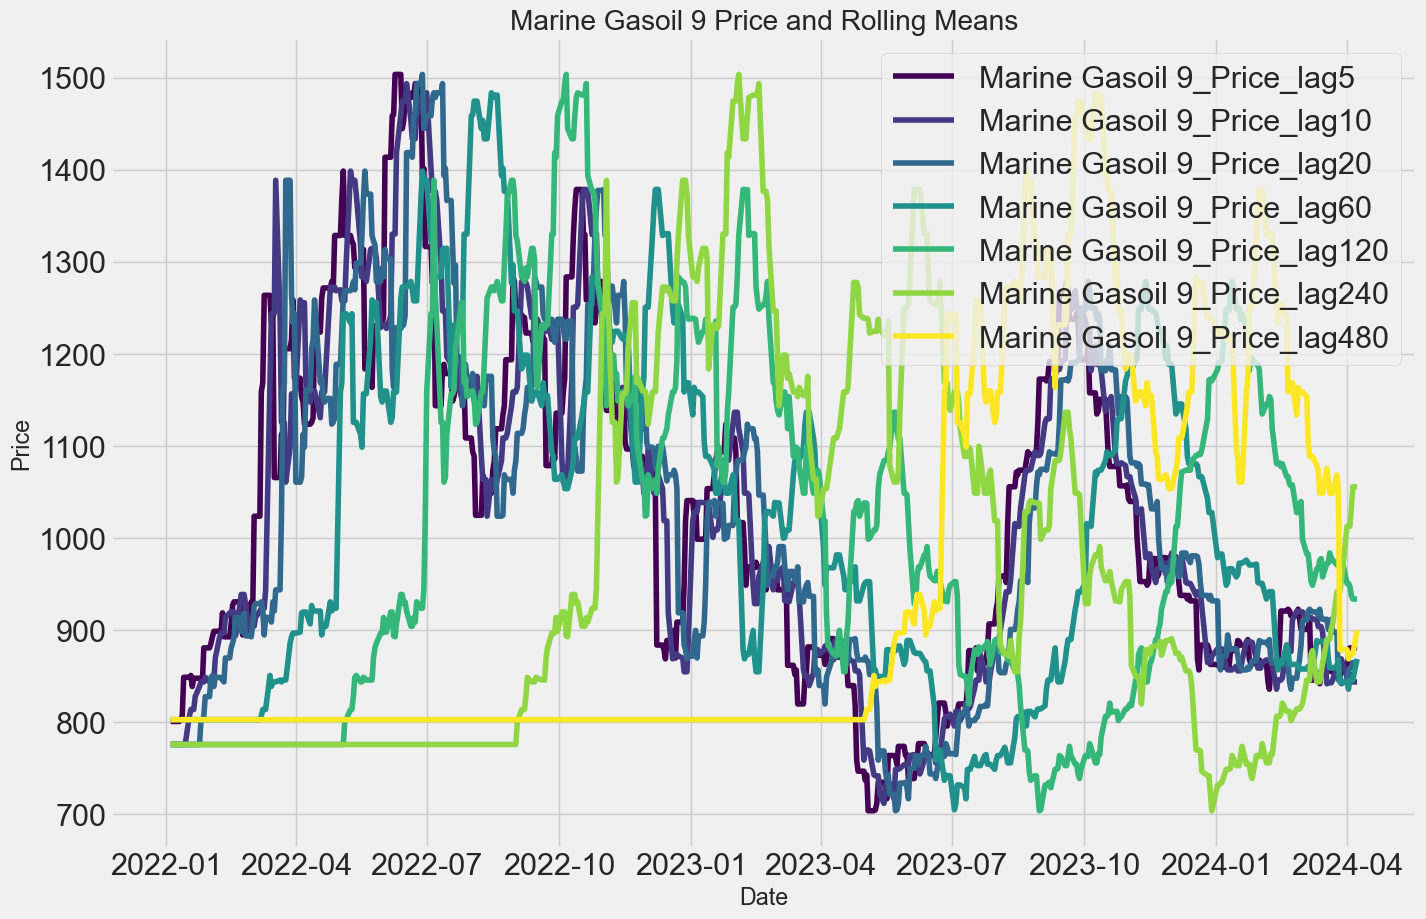

In [28]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag5',
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120',
    'Marine Gasoil 9_Price_lag240',
    'Marine Gasoil 9_Price_lag480'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## __5.4 dummies__

In [29]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

In [30]:
test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [31]:
train_val

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_rolling240,Marine Gasoil 9_Price_lag5,...,Marine Gasoil 9_Price_lag120,Marine Gasoil 9_Price_lag240,Marine Gasoil 9_Price_lag480,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,775.5,846.550,-1.554101,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,775.5,775.5,802.5,2022,1,1,1,4,1,4
2022-01-05,800.5,846.550,-3.835135,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,775.5,775.5,802.5,2022,1,1,2,5,1,5
2022-01-06,802.5,846.550,-1.155825,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,775.5,775.5,802.5,2022,1,1,3,6,1,6
2022-01-07,806.5,846.550,1.645037,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,775.5,775.5,802.5,2022,1,1,4,7,1,7
2022-01-10,813.5,846.550,6.737278,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,775.5,775.5,802.5,2022,1,1,0,10,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,877.5,869.800,-1.554101,864.5,859.2,857.80,876.083333,918.108333,934.102083,872.5,...,950.5,1012.5,868.5,2024,2,4,1,2,14,93
2024-04-03,880.5,870.025,-3.835135,871.9,860.8,856.95,876.316667,916.375000,934.677083,880.5,...,947.5,1012.5,873.5,2024,2,4,2,3,14,94
2024-04-04,881.5,870.175,-1.155825,877.1,863.5,858.75,876.383333,914.716667,935.260417,880.5,...,937.5,1032.5,873.5,2024,2,4,3,4,14,95


# __6. Machine Learning__

In [32]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((565, 23), (20, 23), (10, 23))

In [33]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [34]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:linear', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1229.78463
[100]	validation_0-rmse:480.63349
[200]	validation_0-rmse:220.04083
[300]	validation_0-rmse:140.28654
[400]	validation_0-rmse:116.33448
[500]	validation_0-rmse:109.33673
[600]	validation_0-rmse:106.95746
[700]	validation_0-rmse:106.05583
[800]	validation_0-rmse:105.37245
[900]	validation_0-rmse:105.05198
[1000]	validation_0-rmse:104.85490
[1100]	validation_0-rmse:104.77482
[1200]	validation_0-rmse:104.68884
[1300]	validation_0-rmse:104.64372
[1341]	validation_0-rmse:104.64311
[0]	validation_0-rmse:1068.99740
[100]	validation_0-rmse:403.14462
[200]	validation_0-rmse:158.50832
[300]	validation_0-rmse:78.34782
[400]	validation_0-rmse:57.46993
[500]	validation_0-rmse:53.56299
[600]	validation_0-rmse:53.16885
[609]	validation_0-rmse:53.16370
[0]	validation_0-rmse:811.08028
[100]	validation_0-rmse:258.77994
[200]	validation_0-rmse:85.31054
[300]	validation_0-rmse:41.27152
[386]	validation_0-rmse:41.26534
[0]	validation_0-rmse:1058.67381
[100]	validation_0-rms

In [36]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [79.28898447567654, 44.23138176043009, 34.34956595823937, 23.01485419519169, 12.077593931217784]
Average MAE across folds: 38.59
RMSE for each fold: [104.63708039732305, 53.142801216865855, 39.659460624202815, 28.531290537988546, 15.87173408585906]
Average RMSE across folds: 48.37
MAPE for each fold: [6.201090041131648, 4.270928902878335, 4.264658731384992, 2.186306613189411, 1.3638652922535799]
Average MAPE across folds: 3.66


In [37]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:880.29629
[100]	validation_0-rmse:322.74985
[200]	validation_0-rmse:119.08197
[300]	validation_0-rmse:46.69728
[400]	validation_0-rmse:23.43817
[500]	validation_0-rmse:17.64151
[600]	validation_0-rmse:16.24464
[700]	validation_0-rmse:15.89355
[800]	validation_0-rmse:15.88646
[900]	validation_0-rmse:15.90255
[905]	validation_0-rmse:15.89579


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [38]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_xgb_val_cv,prediction_xgb_cv
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,842.522644
2024-04-17,865.5,NaN,846.026184
2024-04-18,859.5,NaN,847.547791


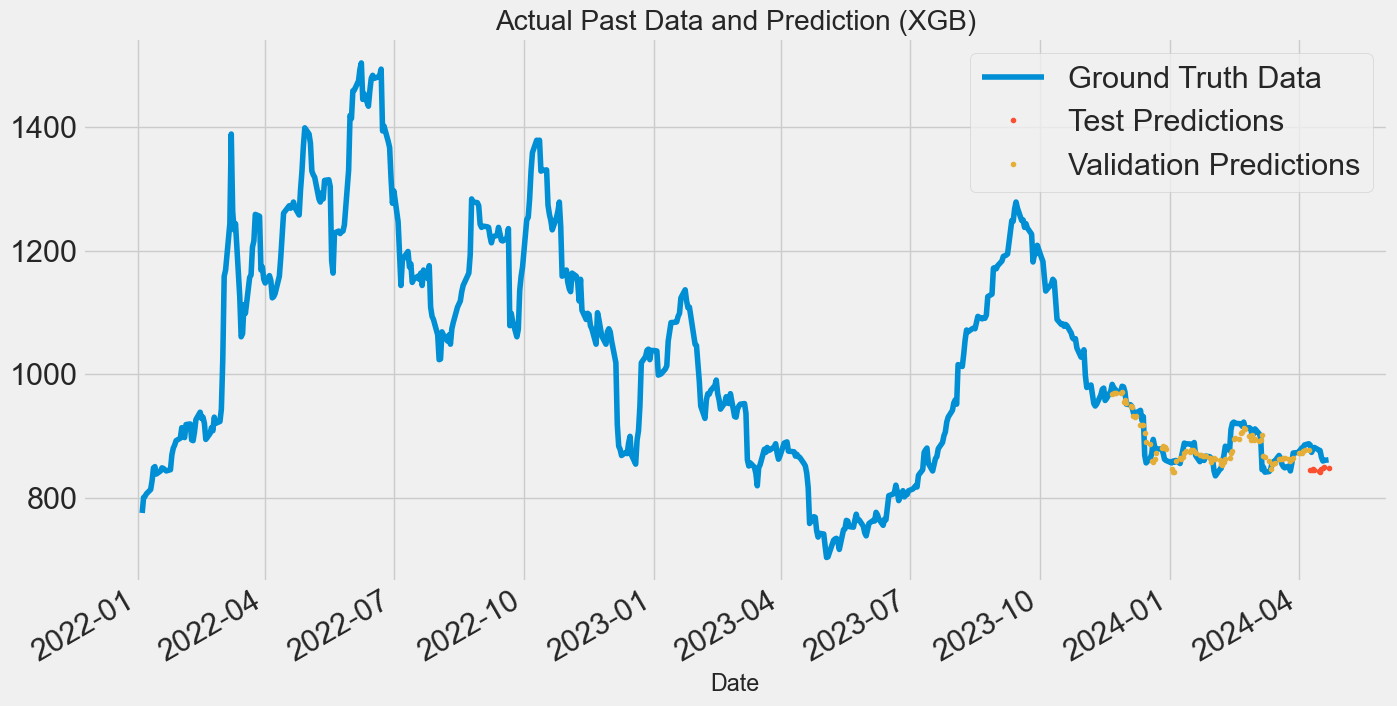

In [39]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='.')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

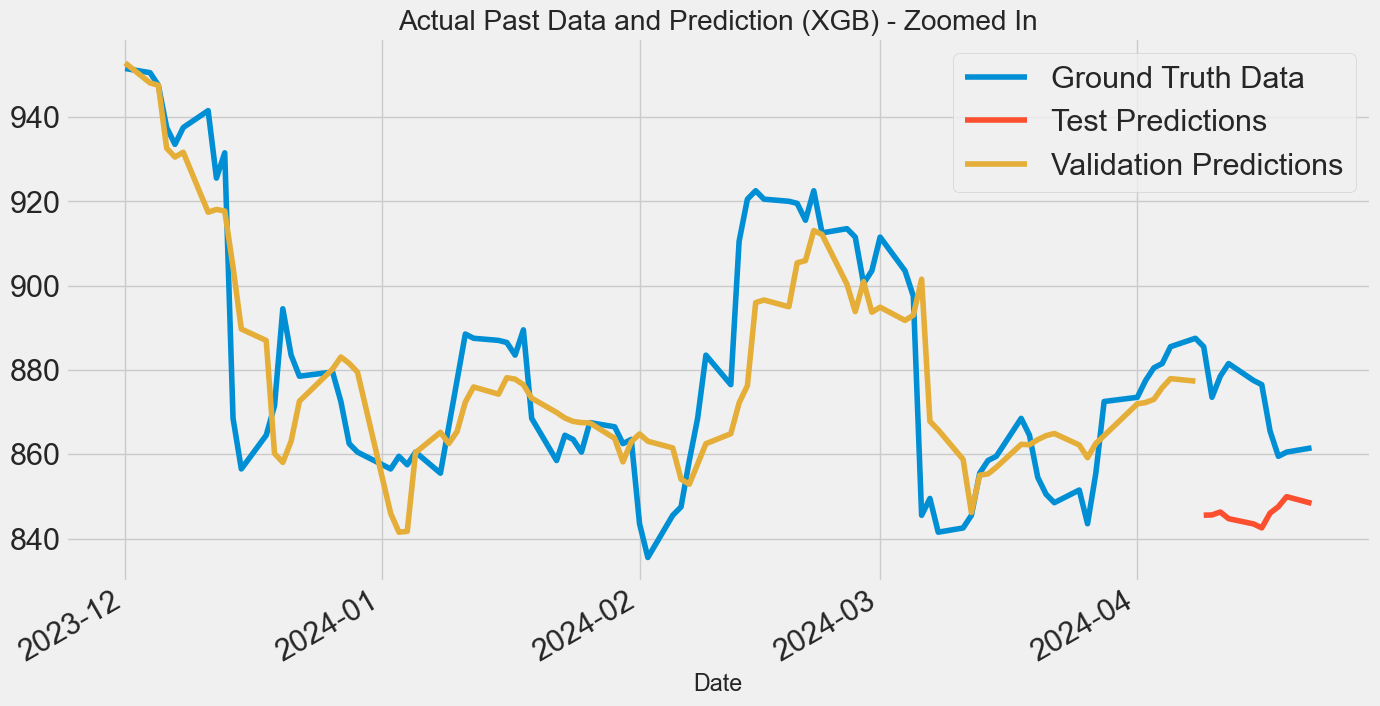

In [50]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 12.08
RMSE Score on Validation set (XGB): 15.87
MAPE Score on Validation set (XGB): 1.36%


In [44]:
ts_clean = ts.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 26.00
RMSE Score on Validation set (XGB): 28.08
MAPE Score on Validation set (XGB): 2.97%


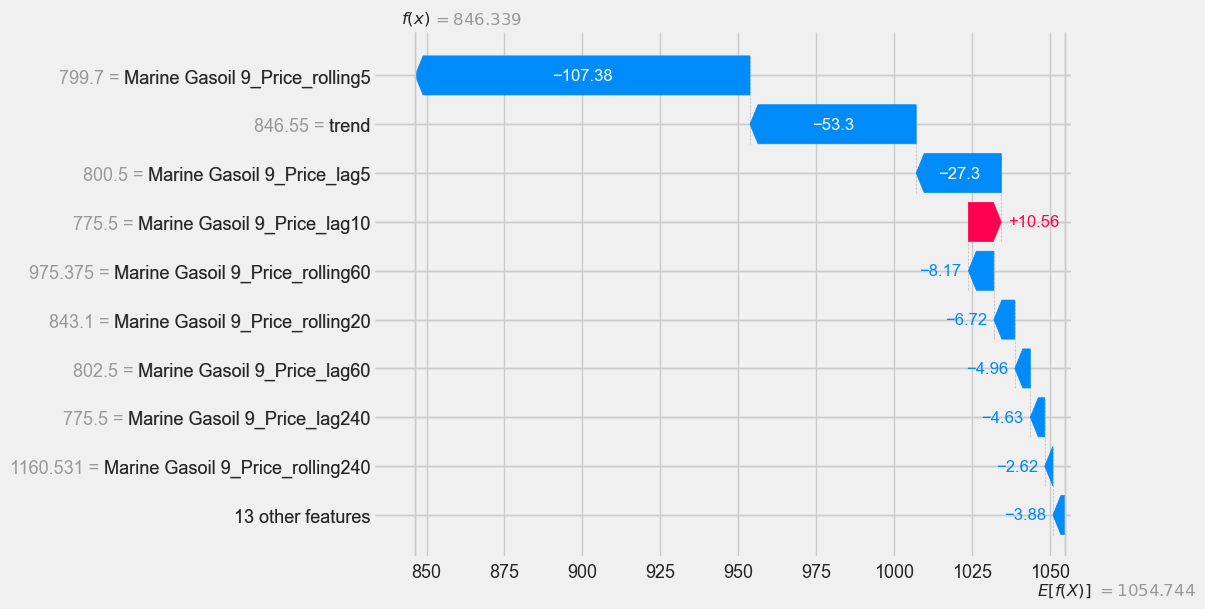

In [46]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

In [ ]:
test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape


validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape